# Get Click Coordinates For Full Face, But Split in the Middle

### import packages

In [1]:
import pickle
import json

import numpy as np
import pandas as pd

import cv2
from skimage import filters
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

from matplotlib.colors import ListedColormap

from tqdm.notebook import tqdm

### get color palettes

In [2]:
with open('../models/palette.pkl', 'rb') as fp:
    color_palette = pickle.load(fp)
    
with open('../models/red_palette.pkl', 'rb') as fp:
    red_palette = pickle.load(fp)

### get im dims

In [3]:
with open('../data/interim/im_dims.json', 'r') as fp:
    dim_dict = json.load(fp)

n_rows = dim_dict['n_rows']
n_cols = dim_dict['n_cols']
new_n_rows = dim_dict['new_n_rows']
new_n_cols = dim_dict['new_n_cols']
scale_factor = dim_dict['scale_factor']

### get stimuli

In [4]:
stim_df = pd.read_csv('../data/interim/stim_df.tsv', sep='\t', index_col=[0, 1, 2])
stim_df.tail()

file_name    cut
Upper Surprised AM02  ../stim/AM02SUS-MU.jpg  432.0
                AM04  ../stim/AM04SUS-MU.jpg  432.0
                AM06  ../stim/AM06SUS-MU.jpg  432.0
                AM23  ../stim/AM23SUS-MU.jpg  432.0
                AM32  ../stim/AM32SUS-MU.jpg  432.0

### get data

In [5]:
data_df = pd.read_csv('../data/interim/big_df.tsv', sep='\t', index_col=[0, 1], header=[0, 1, 2])
data_df.head(5)

Full  \
                                                       Fearful   
                                                          AF01   
p001 upper                                                   6   
     lower                                                   3   
     coords  [(333.0, 387.0), (379.0, 384.0), (246.0, 393.0...   
     diff                                                    3   
     Answer                                            Fearful   

                                                                \
                                                                 
                                                          AF05   
p001 upper                                                   8   
     lower                                                   2   
     coords  [(324.0, 392.0), (375.0, 390.0), (377.0, 357.0...   
     diff                                                    6   
     Answer                                              Angry   

                                                                \
                                                                 
                                                          AF07   
p001 upper                                                   4   
     lower                                                   6   
     coords  [(293.0, 511.0), (272.0, 587.0), (331.0, 488.0...   
     diff                                                   -2   
     Answer                                              Angry   

                                                                \
                                                                 
                                                          AF14   
p001 upper                                                   6   
     lower                                                   3   
     coords  [(311.0, 386.0), (386.0, 383.0), (236.0, 394.0...   
     diff                                                    3   
     Answer                                            Fearful   

                                                                \
                                                                 
                                                          AF30   
p001 upper                                                   4   
     lower                                                   4   
     coords  [(323.0, 545.0), (240.0, 552.0), (241.0, 472.0...   
     diff                                                    0   
     Answer                                                Sad   

                                                                \
                                                                 
                                                          AM02   
p001 upper                                                   5   
     lower                                                   4   
     coords  [(343.0, 548.0), (231.0, 540.0), (279.0, 465.0...   
     diff                                                    1   
     Answer                                          Surprised   

                                                                \
                                                                 
                                                          AM04   
p001 upper                                                   5   
     lower                                                   2   
     coords  [(324.0, 384.0), (381.0, 384.0), (244.0, 390.0...   
     diff                                                    3   
     Answer                                            Fearful   

                                                                \
                                                                 
                                                          AM06   
p001 upper                                                   6   
     lower                                                   3   
     coords  [(313.0, 394

### put coordinates into numpy array

In [6]:
def make_array(p_num, im_key, half, data_df, n_rows=n_rows, n_cols=n_cols, stim_df=stim_df):
    
    these_coords = eval(data_df.loc[(p_num, 'coords'), im_key])

    zero_array = np.zeros((n_rows, n_cols))
    
    for (x, y) in these_coords:
        
        if half == 'Upper':
            
            if y < stim_df.loc[im_key, 'cut']:
                x, y = int(x), int(y)
                zero_array[(y, x)] = 1
                
        elif half == 'Lower':
            
            if y >= stim_df.loc[im_key, 'cut']:
                x, y = int(x), int(y)
                zero_array[(y, x)] = 1  
                
        else:
            x, y = int(x), int(y)
            zero_array[(y, x)] = 1              
                
    return zero_array

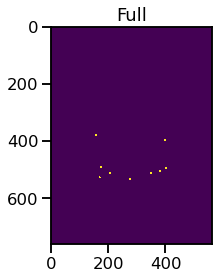

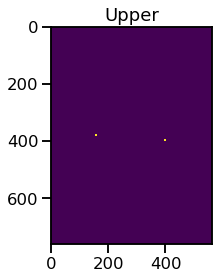

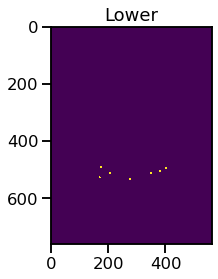

In [7]:
for half in ['Full', 'Upper', 'Lower']:
    this_array = make_array('p003', ('Full', 'Happy', 'AF01'), half, data_df)
    plt.imshow(this_array, vmax=0.000001)
    plt.title(half)
    plt.show()

### increase size of clicks

In [8]:
def make_smooth(zero_array, my_sigma=10, my_binarizer=.0001):  # OR: .0005 ?
    
    fa = filters.gaussian(zero_array, sigma=my_sigma)
    fa = fa>my_binarizer
    fa = fa.astype(int)
    
    return fa

### get all identities of one emo/condition for one participant

In [9]:
def make_big_zero_dict(p_num, emo, half, cond='Full', data_df=data_df, n_rows=n_rows, n_cols=n_cols):
    
    big_zero_dict = {}

    for ident in data_df.columns.levels[2]:
        
        im_key = (cond, emo, ident)
        zero_array = make_array(p_num, im_key, half, data_df)
        bin_array = make_smooth(zero_array)

        answer = data_df.loc[(p_num, 'Answer'), im_key]
        
        big_zero_dict[(answer,ident)] = bin_array

    return big_zero_dict

In [10]:
def make_big_zero_array(big_zero_dict, ans):
    
    big_zero_array = np.zeros_like( big_zero_dict[ list(big_zero_dict.keys())[-1] ] )
    
    for i in big_zero_dict:
        if i[0] == ans:
            big_zero_array += big_zero_dict[i]

    return big_zero_array

### df, by face ident

In [11]:
def make_this_flat(emo, half, p_num):
    
    big_zero_dict = make_big_zero_dict(p_num, emo, half)
    
    flat_dict = {}
    for ans, i in big_zero_dict:
        flat_dict[(ans, i)] = big_zero_dict[(ans, i)].flatten()
    flat_df = pd.DataFrame(flat_dict).T
    
    flat_df.index = pd.MultiIndex.from_tuples([(half, emo, i[0], i[1], p_num) for i in flat_df.index])
    flat_df = flat_df.sort_index()
    
    return flat_df

In [12]:
make_this_flat('Happy', 'Lower', 'p003')

0       1       2       3       4       5       \
Lower Happy Happy AF01 p003       0       0       0       0       0       0   
                  AF05 p003       0       0       0       0       0       0   
                  AF07 p003       0       0       0       0       0       0   
                  AF14 p003       0       0       0       0       0       0   
                  AF30 p003       0       0       0       0       0       0   
                  AM02 p003       0       0       0       0       0       0   
                  AM04 p003       0       0       0       0       0       0   
                  AM06 p003       0       0       0       0       0       0   
                  AM23 p003       0       0       0       0       0       0   
                  AM32 p003       0       0       0       0       0       0   

                             6       7       8       9       ...  428234  \
Lower Happy Happy AF01 p003       0       0       0       0  ...       0   
                  AF05 p003       0       0       0       0  ...       0   
                  AF07 p003       0       0       0       0  ...       0   
                  AF14 p003       0       0       0       0  ...       0   
                  AF30 p003       0       0       0       0  ...       0   
                  AM02 p003       0       0       0       0  ...       0   
                  AM04 p003       0       0       0       0  ...       0   
                  AM06 p003       0       0       0       0  ...       0   
                  AM23 p003       0       0       0       0  ...       0   
                  AM32 p003       0       0       0       0  ...       0   

                             428235  428236  428237  428238  428239  428240  \
Lower Happy Happy AF01 p003       0       0       0       0       0       0   
                  AF05 p003       0       0       0       0       0       0   
                  AF07 p003       0       0       0       0       0       0   
                  AF14 p003       0       0       0       0       0       0   
                  AF30 p003       0       0       0       0       0       0   
                  AM02 p003       0       0       0       0       0       0   
                  AM04 p003       0       0       0       0       0       0   
                  AM06 p003       0       0       0       0       0       0   
                  AM23 p003       0       0       0       0       0       0   
                  AM32 p003       0       0       0       0       0       0   

                             428241  428242  428243  
Lower Happy Happy AF01 p003       0       0       0  
                  AF05 p003       0       0       0  
                  AF07 p003       0       0       0  
                  AF14 p003       0       0       0  
                  AF30 p003       0       0       0  
                  AM02 p003       0       0       0  
                  AM04 p003       0       0       0  
                  AM06 p003       0       0       0  
                  AM23 p003       0       0       0  
                  AM32 p003       0       0       0  

[10 rows x 428244 columns]

### define how to bin the data

In [13]:
def make_scale_bins(scale_factor, n_rows=n_rows, n_cols=n_cols):    
    
    sf = scale_factor
    
    x_bins = np.array([[i]*sf for i in range(round(n_rows/sf)+sf)]).flatten()[:n_rows]
    y_bins = np.array([[i]*sf for i in range(round(n_cols/sf)+sf)]).flatten()[:n_cols]
    
    return x_bins, y_bins

In [14]:
x_bins, y_bins = make_scale_bins(scale_factor)

### apply binning to already flattened data

In [15]:
def make_downsample(this_data, n_rows=n_rows, n_cols=n_cols, x_bins=x_bins, y_bins=y_bins):
    
    # bring back to original shape
    im = this_data.values.reshape(n_rows, n_cols)
    # make dataframe                
    new_im = pd.DataFrame(im)
    # add binning to multiindex
    new_im.index = pd.MultiIndex.from_arrays([x_bins, new_im.index])
    new_im.columns = pd.MultiIndex.from_arrays([y_bins, new_im.columns])
    # average over bins
    lo_im = new_im.groupby(level=0, axis=0).max().groupby(level=0, axis=1).max()
    # make flat again
    new_data = lo_im.values.flatten()

    return new_data

### for all in one package

In [16]:
def make_all_downsample(flat_df):

    new_df = pd.DataFrame()
    for i in flat_df.index:
        
        this_data  = flat_df.loc[i]
        
        down_data = make_downsample(this_data)
        
        this_df = pd.DataFrame(down_data).T
        this_df.index = pd.MultiIndex.from_tuples([i])
        
        new_df = pd.concat([new_df, this_df])
        
    return new_df

### collect all data

(Downsampled to avoid memory issues)

In [17]:
def make_big_flat_df(half, data_df):
    
    p_nums = data_df.index.levels[0]
    emos = data_df.columns.levels[1]
    
    big_flat_df = pd.DataFrame()
    
    for emo in tqdm(emos, leave=False):
        
        emo_df = pd.DataFrame()
    
        for p_num in tqdm(p_nums, leave=False): 
            
            flat_df = make_this_flat(emo, half, p_num)
            new_df = make_all_downsample(flat_df) # downsample
            
            emo_df = pd.concat([emo_df, new_df])

        big_flat_df = pd.concat([big_flat_df, emo_df])

    big_flat_df = big_flat_df.sort_index()
    
    return big_flat_df

#### do for all conditions and store by condition

In [18]:
for half in tqdm(['Upper', 'Lower', 'Full']):
    
    biggest_flat_df = make_big_flat_df(half, data_df)
    
    with open(f'../data/interim/biggest_{half}_CUTUP_flat_df.pkl', 'wb') as fp:
        pickle.dump(biggest_flat_df.loc[half, :], fp)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]